In [17]:
# Libaries
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [4]:
# Define the new working directory path
new_working_directory = r'/Users/nicol1/Documents/GitHub/sports-data'

# Change the current working directory
os.chdir(new_working_directory)

In [5]:
# Define the path 
data_folder = 'data/'

# Load the CSV files to df
cleaned_df = pd.read_csv(data_folder + 'cleaned_df.csv')
cleaned_df

,player_id,name,competition_id,country,height,foot,position,highest_market_value,number_games_played,total_minutes,...,red_cards_sum,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year
0,122011,Markus Henriksen,ELQ,Norway,187.0,right,Defender,5000000.0,165,12199,...,1,0.006061,33,0.200000,22,45.0,6,27.500000,5.500000,3.666667
1,14940,Razvan Rat,UKRS,Romania,179.0,left,Defender,6500000.0,97,7690,...,1,0.010309,3,0.030928,13,43.0,5,19.400000,0.600000,2.600000
2,14942,Darijo Srna,UKRS,Croatia,182.0,right,Defender,17500000.0,227,19598,...,2,0.008811,22,0.096916,68,45.0,8,28.375000,2.750000,8.500000
3,26267,Fernandinho,UKRS,Brazil,179.0,right,Midfield,32000000.0,399,30325,...,3,0.007519,29,0.072682,41,42.0,11,36.272727,2.636364,3.727273
4,55735,Henrikh Mkhitaryan,UKRS,Armenia,177.0,both,Midfield,37000000.0,485,35878,...,0,0.000000,128,0.263918,119,43.0,13,37.307692,9.846154,9.153846
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25919,330126,Karol Świderski,IT1,Poland,184.0,left,Attack,6000000.0,89,4336,...,0,0.000000,28,0.314607,10,NaN,5,17.800000,5.600000,2.000000
25920,26485,Jérôme Boateng,IT1,Germany,192.0,right,Defender,45000000.0,351,27803,...,5,0.014245,10,0.028490,26,NaN,13,27.000000,0.769231,2.000000
25921,470422,Triantafyllos Pasalidis,IT1,Greece,185.0,right,Defender,1000000.0,142,11424,...,1,0.007042,3,0.021127,2,NaN,8,17.750000,0.375000,0.250000
25922,872184,Tadeo Allende,ES1,Argentina,183.0,right,Attack,4500000.0,1,17,...,0,0.000000,0,0.000000,0,NaN,1,1.000000,0.000000,0.000000


In [6]:
# Filter the position for goalkeeper
goalkeeper_df = cleaned_df[cleaned_df['position'] == 'Goalkeeper']
goalkeeper_df
#print(goalkeeper_df.head)

,player_id,name,competition_id,country,height,foot,position,highest_market_value,number_games_played,total_minutes,...,red_cards_sum,red_cards_avg,goals,avg_goals_per_game,assists,age,year,avg_games_per_year,avg_goals_per_year,avg_assists_per_year
24,48015,Lukas Hradecky,DK1,Finland,192.0,right,Goalkeeper,12000000.0,469,42378,...,2,0.004264,0,0.0,0,42.0,13,36.076923,0.0,0.000000
27,107775,Frederik Rönnow,DK1,Denmark,188.0,right,Goalkeeper,5500000.0,279,25042,...,1,0.003584,0,0.0,0,NaN,12,23.250000,0.0,0.000000
45,14937,Stipe Pletikosa,RU1,Croatia,193.0,right,Goalkeeper,6800000.0,98,8822,...,0,0.000000,0,0.0,0,41.0,5,19.600000,0.0,0.000000
50,12518,Silvio Proto,BESC,Belgium,184.0,right,Goalkeeper,4200000.0,199,17889,...,1,0.005025,0,0.0,1,44.0,9,22.111111,0.0,0.111111
60,69001,Giedrius Arlauskis,RU1,Lithuania,191.0,left,Goalkeeper,2500000.0,12,923,...,0,0.000000,0,0.0,0,NaN,4,3.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25867,226073,Ivo Grbic,FAC,Croatia,195.0,right,Goalkeeper,7000000.0,43,3673,...,0,0.000000,0,0.0,0,NaN,5,8.600000,0.0,0.000000
25884,336077,Altay Bayındır,FAC,Turkey,198.0,right,Goalkeeper,16000000.0,155,13962,...,0,0.000000,0,0.0,1,NaN,7,22.142857,0.0,0.142857
25887,226073,Ivo Grbic,GB1,Croatia,195.0,right,Goalkeeper,7000000.0,43,3673,...,0,0.000000,0,0.0,0,NaN,5,8.600000,0.0,0.000000
25893,667991,Alaa Bellaarouch,FR1,Morocco,188.0,right,Goalkeeper,200000.0,1,90,...,0,0.000000,0,0.0,0,NaN,1,1.000000,0.0,0.000000


In [13]:
# drop NaN values
goalkeeper_df = goalkeeper_df.dropna()

# Divide data into IV (X) y DV (y)
X = goalkeeper_df[['number_games_played', 'total_minutes', 'average_minutes', 'yellow_cards_sum', 
          'yellow_cards_avg', 'red_cards_sum', 'red_cards_avg', 'goals', 'avg_goals_per_game', 
          'assists', 'age', 'year', 'avg_games_per_year', 'avg_goals_per_year', 'avg_assists_per_year']]
y = goalkeeper_df['highest_market_value']

# Divide data into trial and error 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [14]:
from sklearn.linear_model import LinearRegression

# Initialize Linear Regression Model
model = LinearRegression()

# Train
model.fit(X_train, y_train)


LinearRegression()

In [15]:
# Select only numeric columns
numeric_columns = goalkeeper_df.select_dtypes(include=['float64', 'int64'])

# Calculate correlation matrix
correlation_matrix = numeric_columns.corr()

# Print corr matrix
print(correlation_matrix['highest_market_value'].sort_values(ascending=False))



highest_market_value    1.000000
total_minutes           0.702211
number_games_played     0.701039
avg_games_per_year      0.647962
assists                 0.527164
year                    0.503239
yellow_cards_sum        0.482255
avg_assists_per_year    0.340391
red_cards_sum           0.232863
player_id               0.171477
height                  0.153181
average_minutes         0.146025
avg_goals_per_year     -0.009812
goals                  -0.009812
avg_goals_per_game     -0.010229
age                    -0.013262
red_cards_avg          -0.037032
yellow_cards_avg       -0.065066
Name: highest_market_value, dtype: float64


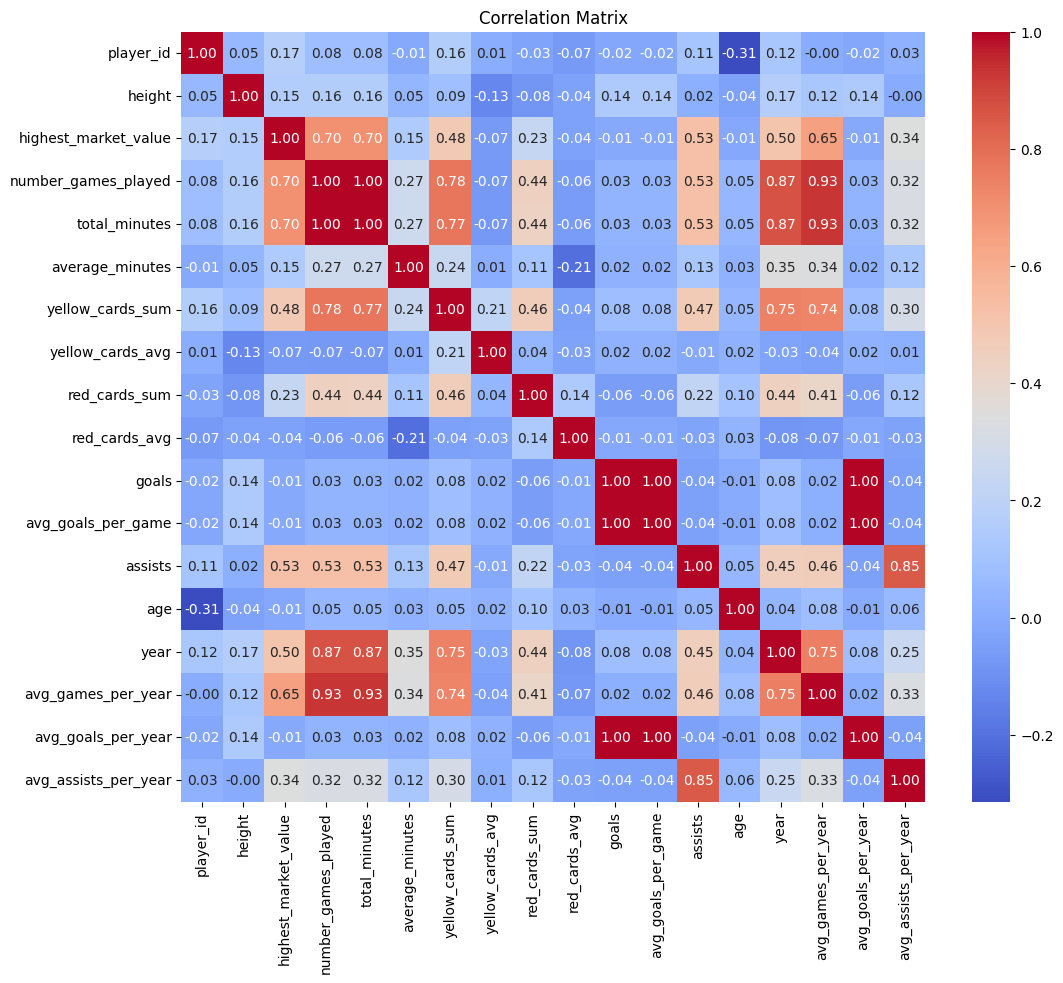

In [18]:
# Plotting correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#Notes to Correlation Matrix:
We have a correlation of 1 for total minutes and number of games played. 
